In [1]:
import simpy
import random
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import warnings

In [2]:
class FiFoServers:
    def __init__(self, env, mu, num_servers):
        self.mu = mu
        self.server = simpy.Resource(env, capacity=num_servers)
        self.processing_times = []
        self.final_arrival = 1
        self.N = 0
        self.queue_length = 0

class SJFServers:
    def __init__(self, env, mu, num_servers):
        self.mu = mu
        self.server = simpy.PriorityResource(env, capacity=num_servers)
        self.processing_times = []
        self.final_arrival = 1
        self.N = 0
        self.queue_length = 0

def task(name, env, servers, processing_time, waiting_times, print_tasks):

    # A task arrives at the server
    start_time = env.now
    if print_tasks:
        print(f'Task {name} arriving at {start_time}')
    
    servers.final_arrival = start_time
    servers.N += 1
    servers.queue_length += 1

    # Request task to server
    with servers.server.request() as req:

        # Once there is availability at the server, initiate task
        yield req
        end_time = env.now
        servers.queue_length -= 1
  
        if print_tasks:
            print(f'Server starts processing {name} at {end_time}')

        yield env.timeout(processing_time)

        if print_tasks:
            print(f'Server done processing {name} at {env.now}')

        waiting_times.append(end_time - start_time)
        servers.processing_times.append(processing_time)


def get_confidence(data, p=0.95):
    """
    Calculate the mean and confidence interval of a dataset for a given confidence level.

    Parameters:
    - data (array-like): Input data.
    - p (float, optional): Confidence level (default is 0.95).

    Returns:
    tuple: A tuple containing the mean and the confidence interval.
    """

    mean = np.mean(data)
    n = len(data)
    lamb = stats.t.ppf((1 + p) / 2, n - 1)
    sigma = np.std(data)
    confidence = (lamb * sigma / np.sqrt(n))
    return mean, confidence

In [3]:
def task_generator(env, servers, N, lambda_, waiting_times, print_tasks=False):

    # Generate N tasks
    for i in range(N):
        
        # Calculate time at server by Poisson process, not sure if necessary
        processing_time = random.expovariate(servers.mu)

        # Create task
        env.process(task(i, env, servers, processing_time, waiting_times, print_tasks))

        # Calculate time until next task by Poisson process, not sure if necessary
        next_arrival = random.expovariate(lambda_)
        yield env.timeout(next_arrival)

def task_generator_long_tail(env, servers, N, lambda_, waiting_times, print_tasks=False):
    
    
    
    for i in range(N):
        u = np.random.rand()
        if u <= 0.75:
            processing_time = random.expovariate(servers.mu)
        else:
            processing_time = random.expovariate(0.4*servers.mu)
        # Create task
        env.process(task(i, env, servers, processing_time, waiting_times, print_tasks))

        # Calculate time until next task by Poisson process, not sure if necessary
        next_arrival = random.expovariate(lambda_)
        yield env.timeout(next_arrival)

def task_generator_deter(env, servers, N, lambda_, waiting_times, print_tasks=False):
    
    for i in range(N):
        processing_time = 1/servers.mu

        # Create task
        env.process(task(i, env, servers, processing_time, waiting_times, print_tasks))

        # Calculate time until next task by Poisson process, not sure if necessary
        next_arrival = random.expovariate(lambda_)
        yield env.timeout(next_arrival)

In [4]:
def run_simulation(num_servers, mu, lambda_, N, scheduler, print_statistics, mode):
    env = simpy.Environment()

    # Use either First-in First-out or Shortest Job First scheduling
    if scheduler.lower() == 'fifo':
        servers = FiFoServers(env, mu, num_servers)
    elif scheduler.lower() == 'sjf':
        servers = SJFServers(env, mu, num_servers)

    waiting_times = []

    # Generate tasks
    
    if mode == 'deter':
        env.process(task_generator_deter(env, servers, N, lambda_ * num_servers, waiting_times))
        env.run()
    elif mode == 'long tail':
        env.process(task_generator_long_tail(env, servers, N, lambda_ * num_servers, waiting_times))
        env.run()
    elif mode == 'Markov':
        env.process(task_generator(env, servers, N, lambda_ * num_servers, waiting_times))
        env.run()
    
    # Calculate statistics on waiting times
    waiting_times_array = np.array(waiting_times)
    confidence_level = 0.95

    # Calculate confidence interval of waiting time
    mean_waitingtime, confidence_waitingtime = get_confidence(waiting_times_array, confidence_level)

    # Calculate statistics on processing times
    processing_times_array = np.array(servers.processing_times)

    # Calculate confidence interval of processing rate
    mean, confidence = get_confidence(processing_times_array, confidence_level)

    if print_statistics:

        std_waiting_time = np.std(waiting_times_array)
        confidence_interval = (mean_waitingtime - confidence_waitingtime, mean_waitingtime + confidence_waitingtime)

        print(f"{num_servers} server(s):")
        print(f"Average Waiting Time: {mean_waitingtime}")
        print(f"Standard Deviation of Waiting Time: {std_waiting_time}")
        print(f"Confidence Interval (95%): {confidence_interval}\n")
        
        processing_rates_array = 1 / processing_times_array[processing_times_array > 0]
        std_processing_rate = np.std(processing_rates_array)
        confidence_interval = (1 / (mean + confidence), 1 / (mean - confidence))

        print(f"Average Processing Rate of server: {1 / mean}")
        print(f"Standard deviation of Processing Rate {std_processing_rate}")
        print(f"Confidence Interval (95%): {confidence_interval}\n")

        # Print statistics on arrivals
        print(f"Time of final arrival: {servers.final_arrival}")
        print(f"Number of arrivals: {servers.N}")
        print(f"Average arrivals per timestep: {servers.N / servers.final_arrival}\n\n")

    return mean_waitingtime, confidence_waitingtime


In [102]:
def generate_waitingtimes(lambda_, mus, N, num_servers_list, scheduler, mode, n=1):
    """Generates data for the average waiting times with different servers and different system loads."""
    
    ## Ignore division by 0 warnings
    warnings.filterwarnings("ignore", category=RuntimeWarning) 

    data = {}

    # Loop over number of servers
    for num_servers in num_servers_list:
        waitingtimes = []
        confidences = []

        # Loop over different values for rho by varying mu
        for mu in mus:
            waiting_times_for_simulations = []

            # Run simulation multiple times
            for _ in range(n):
                mean_waitingtime, confidence_waitingtime = run_simulation(num_servers, mu, lambda_, N, scheduler, False, mode)
                if n == 1:
                    confidences.append(confidence_waitingtime)
                    waitingtimes.append(mean_waitingtime)
                else:
                    waiting_times_for_simulations.append(mean_waitingtime)

            if n > 1:
                # Calculate mean and confidence interval using the get_confidence function
                mean, confidence = get_confidence(waiting_times_for_simulations)
                waitingtimes.append(mean)
                confidences.append(confidence)

        data[num_servers] = {'x': lambda_ / mus, 'waitingtimes': waitingtimes, 'confidences': confidences}

    return data

def generate_waitingtimes2(lambda_, mus, N, num_servers_list, scheduler, mode, std_min):
    """
    Generates data for the average waiting times with different servers and different system loads.
    For each average waiting time per a Num_servers and mu, it does n simulations till the standard deviation is less than std_min
    """
    
    ## Ignore division by 0 warnings
    warnings.filterwarnings("ignore", category=RuntimeWarning) 

    data = {}
    
  
    # Loop over number of servers
    for num_servers in num_servers_list:
        waitingtimes = []
        confidences = []
        n_simulations = []

        # Loop over different values for rho by varying mu
        for mu in mus:
            waiting_times_for_simulations = np.array([])
            n = 0 
            # Run simulation multiple times
            while True:
                mean_waitingtime, confidence_waitingtime = run_simulation(num_servers, mu, lambda_, N, scheduler, False, mode)
                waiting_times_for_simulations = np.append(waiting_times_for_simulations, mean_waitingtime)
                std = np.std(waiting_times_for_simulations)
        
                n += 1
                if n > 10 and std/np.sqrt(n) < std_min:
                    # Calculate mean and confidence interval using the get_confidence function
                    mean, confidence = get_confidence(waiting_times_for_simulations)
                    waitingtimes.append(mean)
                    confidences.append(confidence)
                    n_simulations.append(n)
                    break

                elif n > 800:
                    break
        
        data[num_servers] = {'x': lambda_ / mus, 'waitingtimes': waitingtimes, 'confidences': confidences, 'n_simulations': n_simulations}
    return data


def plot_waitingtimes(data, axs):
    """Plots the average waiting times with different servers and different system loads."""
    
    for num_servers, values in data.items():
        x = values['x']
        waitingtimes = values['waitingtimes']
        confidence_waitingtime = np.array(values['confidences'])

        axs.plot(x, waitingtimes, label=f'Number of servers = {num_servers}')
        axs.fill_between(x, waitingtimes - confidence_waitingtime, waitingtimes + confidence_waitingtime, alpha=0.4)

    axs.set_xlabel("System load")
    axs.set_ylabel("Average waiting time")
    axs.legend()

def plot_nsimulations(data,axs):
    """ Plots the number of simulations necessary ta achive the same confidence interval with different servers adn different system loads."""
    for num_servers, values in data.items():
        x = values['x']
        n_simulations = values['n_simulations']

        axs.plot(x, n_simulations, label=f'Number of servers = {num_servers}')

    axs.set_xlabel("System load")
    axs.set_ylabel("Number of simulations")
    axs.legend()

In [9]:
def data_storer(data,name):
    """ 
    Given data in the format  {'x': lambda_ / mus, 'waitingtimes': waitingtimes, 'confidences': confidences, 'n_simulations': n_simulations} it stores it in a , separated csv file 
    THe name of the file is specified in name
    """
    df = pd.DataFrame(data)
    df.to_csv(name)


def data_loader(name):
    """ Given a csv  file containg it returns the data as 
    {'x': lambda_ / mus, 'waitingtimes': waitingtimes, 'confidences': confidences, 'n_simulations': n_simulations} 
    Input:
        - name: The file name, it must have the correct adress! like "Data_Q4_from_0_1\Deter_rho_from01_01steps_M1000__lamba015"""
    df = pd.read_csv(name)
    df.set_index('Unnamed: 0', inplace= True)
    return df.to_dict()

In [96]:
def welch_test(data1,data2):
    """ Welch test"""
    
    num_servers_list = [1,2,4]


    for num_servers in num_servers_list:

        markov_waiting_times = data_markov[num_servers]['waitingtimes']
        deter_waiting_times = data_deter[num_servers]['waitingtimes']
        confidence_p = 0.05

        # Perform the 2 sample t test
        t_test_2_samples = stats.ttest_ind(markov_waiting_times,deter_waiting_times ,equal_var=False)
        passed_null_hypothesis = confidence_p > t_test_2_samples.pvalue
        print(f"Number of servers is {num_servers}")
        print(t_test_2_samples)
        print(passed_null_hypothesis)
        
def correlation(data1,data2, data3):
    num_servers_list =[1,2,4]
    for num_servers in num_servers_list:
        markov = data1[num_servers]['waitingtimes']
        long_tail = data2[num_servers]['waitingtimes']
        deter = data3[num_servers]['waitingtimes']
        data = np.array([markov,long_tail,deter])
        covariance_matrix = np.corrcoef(data)
        print(f"Correlation for {num_servers} servers")
        df = pd.DataFrame(covariance_matrix,columns=['Markov', 'Long tail', 'Deter'], index=['Markov', 'Long tail', 'Deter'])
        print(df)
        print("\n")

def regression_test(data1,data2):
    """ Check if M/D/n and M/M/n have a relationship of a 2"""
    num_servers_list = [1,2,4]
    confidence = 0.05
    for num_servers in num_servers_list:
        data1_waiting_times = data1[num_servers]['waitingtimes']
        data2_waiting_times = data2[num_servers]['waitingtimes']
        slope,_,_,p_value,std_err = stats.linregress(data1_waiting_times, data2_waiting_times)

        if p_value < confidence:
            print(f"For {num_servers} servers, we reject the null Hypothesis with a  slope of {slope} and a pvalue of {p_value}")
        else:
            print(f"For {num_servers} servers we do not reject the null Hypothesis with a slope of {slope} and a pvalue of {p_value}")
            
def error_comparison(data1,data2, num_servers_list):
    error_waitingtimes = {}
    error_n_simulations = {}
    for num_servers in num_servers_list:
        error_waitingtimes[num_servers] = np.mean(np.array(data1[num_servers]['waitingtimes']) - np.array(data2[num_servers]['waitingtimes']))
        error_n_simulations[num_servers] = np.mean(np.array(data1[num_servers]['n_simulations']) - np.array(data2[num_servers]['n_simulations']))

    return error_waitingtimes, error_n_simulations

## No


In [30]:
lambda_ = 0.015
rho = 0.9
Ns = [200, 500, 1000] 
###2000, 5000, 10_000, 20_000, 50_000, 100_000, 200_000, 500_000, 1000_000]
mus = np.array([lambda_ / rho])

ns = np.arange(4, 12)

# 'fifo' or 'jsf'
scheduler = 'fifo'

# 'Markov', 'deter' or 'long tail'
mode = 'Markov'
print_statistics = False

all_data_markov = []
all_data_deter = []
all_data_longtail = []
num_servers_list = [1,2,4]


for N in Ns:
    print(N)
    data = []
    for n in ns:
        confidence = 0
        for i in range(2):

            values = generate_waitingtimes(lambda_, mus, N, num_servers_list, scheduler, mode, n)
            print(values)
            confidence += values['confidences'][0] / 3
        data.append(confidence)
    
    all_data_markov.append(data)



plt.imshow(all_data, origin='lower', extent=[ns[0], ns[-1], Ns[0], Ns[-1]], aspect='auto', vmin=0.1)

colorbar = plt.colorbar(label=f'Confidence')
plt.xlabel('n')
plt.ylabel('N')

200
{1: {'x': array([0.9]), 'waitingtimes': [360.1268792993572], 'confidences': [240.12957264862848]}, 2: {'x': array([0.9]), 'waitingtimes': [191.3323568515218], 'confidences': [102.70988403367652]}, 4: {'x': array([0.9]), 'waitingtimes': [79.78114608736308], 'confidences': [104.24319679954246]}}


KeyError: 'confidences'

KeyboardInterrupt: 

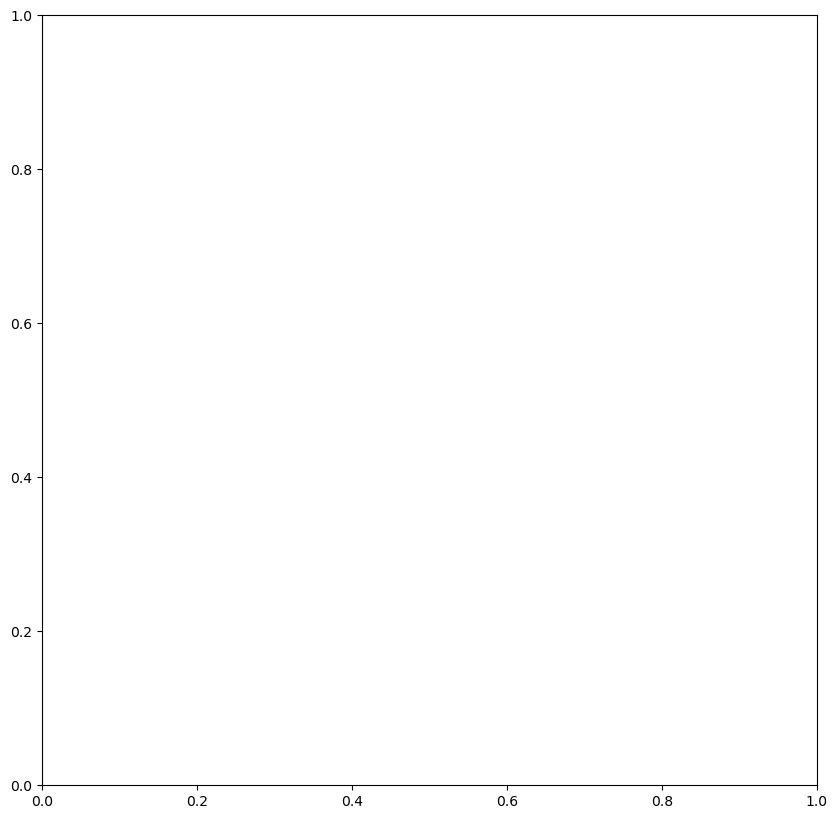

In [9]:
# Parameters
lambda_ = 0.015
N = 10_000
num_servers_list = [1, 2, 4]

# 'fifo' or 'jsf'
scheduler = 'fifo'

# 'Markov', 'deter' or 'long tail'
mode = 'Markov'
print_statistics = False

rho_min, rho_max = 0.1, 0.9
rhos_step = 0.1

rhos = np.arange(rho_min, rho_max + rhos_step, rhos_step)
mus = lambda_ / rhos

std_min = 0.01

# Number of runs. If n = 1, confidence interval is determined by the different waiting times of different tasks
# If n > 1, confidence interval is determined by different average waiting times of those different runs
n = 1

fig, axs = plt.subplots(dpi=100, figsize = (10,10))
data = generate_waitingtimes(lambda_, mus, N, num_servers_list, scheduler, mode)

plot_waitingtimes(data, axs)

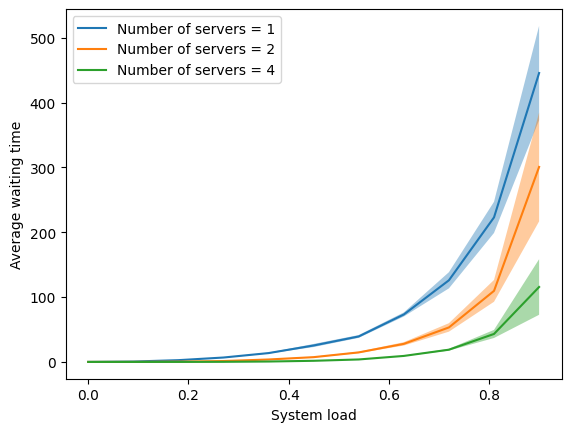

In [355]:
# Parameters
lambda_ = 0.015
N = 10_000
num_servers_list = [1, 2, 4]

# 'fifo' or 'jsf'
scheduler = 'fifo'

# 'Markov', 'deter' or 'long tail'
mode = 'Markov'
print_statistics = False

rho_min, rho_max = 0.0, 0.99
rhos_step = 0.09

rhos = np.arange(rho_min, rho_max, rhos_step)
mus = lambda_ / rhos

# Number of runs. If n = 1, confidence interval is determined by the different waiting times of different tasks
# If n > 1, confidence interval is determined by different average waiting times of those different runs
n = 5

fig, axs = plt.subplots(dpi=100)
data = generate_waitingtimes(lambda_, mus, N, num_servers_list, scheduler, mode, n)

plot_waitingtimes(data, axs)

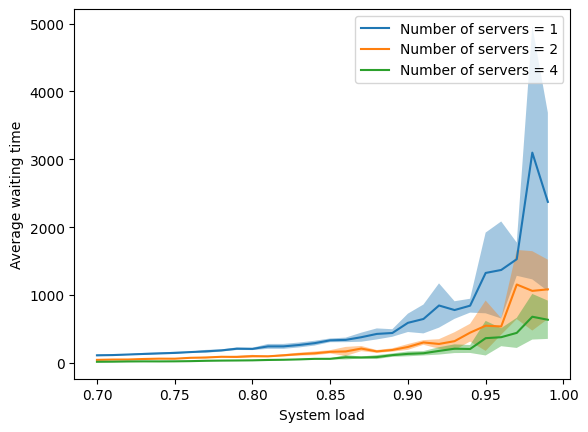

In [356]:
# Parameters
lambda_ = 0.015
N = 10_000
num_servers_list = [1, 2, 4]

# 'fifo' or 'jsf'
scheduler = 'fifo'

# 'Markov', 'deter' or 'long tail'
mode = 'Markov'
print_statistics = False

rho_min, rho_max = 0.7, 0.99
rhos_step = 0.01

rhos = np.arange(rho_min, rho_max, rhos_step)
mus = lambda_ / rhos

# Number of runs. If n = 1, confidence interval is determined by the different waiting times of different tasks
# If n > 1, confidence interval is determined by different average waiting times of those different runs
n = 5

fig, axs = plt.subplots(dpi=100)
data = generate_waitingtimes(lambda_, mus, N, num_servers_list, scheduler, mode, n)

plot_waitingtimes(data, axs)

n way bigger


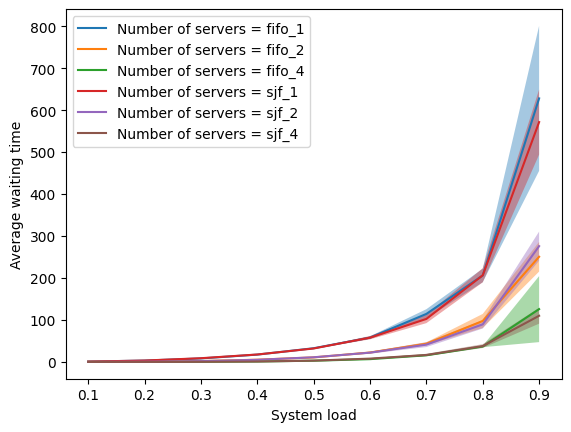

In [365]:
# Parameters
lambda_ = 0.015
N = 10_000
num_servers_list = [1, 2, 4]

# 'fifo' or 'sjf'
scheduler = 'fifo'

# 'Markov', 'deter' or 'long tail'
mode = 'Markov'
print_statistics = False

rho_min, rho_max = 0.1, 0.9
rhos_step = 0.1

rhos = np.arange(rho_min, rho_max + rhos_step, rhos_step)
mus = lambda_ / rhos

# Number of runs. If n = 1, confidence interval is determined by the different waiting times of different tasks
# If n > 1, confidence interval is determined by different average waiting times of those different runs
n = 5

fig, axs = plt.subplots(dpi=100)
fifo_data = generate_waitingtimes(lambda_, mus, N, num_servers_list, scheduler, mode, n)
fifo_data = {'fifo_' + str(key): value for key, value in fifo_data.items()}


scheduler = 'sjf'
sjf_data = generate_waitingtimes(lambda_, mus, N, num_servers_list, scheduler, mode, n)
sjf_data = {'sjf_' + str(key): value for key, value in sjf_data.items()}

data = {**fifo_data, **sjf_data}

plot_waitingtimes(data, axs)

argue by histogram of processing times

hypothesis test that SJF has shorter average waiting times

In [366]:
# Hipothesis to test: Shortest job first has shorter average waiting time

# Step 1. Get the waiting times
for num_servers in num_servers_list:

    sjf_waiting_time = data[f"sjf_{num_servers}"]['waitingtimes']
    fifo_waiting_time = data[f"fifo_{num_servers}"]['waitingtimes']

    # Step 2. Test the null hypothesis (H0): that both samples come from same distribution
    # The T-test "is a test for the null hypothesis that 2 independent samples have identical average (expected) values"
    # See https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
    # For more on tests, see https://www.youtube.com/watch?v=CIbJSX-biu0 

    # Define confidence level to pass the null hypothesis test
    confidence_p = 0.05

    # Check if our data has a significantly different variance (assuming so if greater to smaller variance is > 4:1)
    var_ratio = max(np.var(sjf_waiting_time), np.var(fifo_waiting_time))/min(np.var(sjf_waiting_time), np.var(fifo_waiting_time))
    equal_var = var_ratio < 4

    # Perform the 2 sample t test
    t_test_2_samples = stats.ttest_ind(sjf_waiting_time,fifo_waiting_time ,equal_var=equal_var)
    passed_null_hypothesis = confidence_p > t_test_2_samples.pvalue

    # Print results
    print(f'Waiting times for {num_servers} servers:')
    print('FJS:',sjf_waiting_time)
    print('FIFO:',fifo_waiting_time)
    print()
    print('Averages')
    print('FJS:',np.mean(sjf_waiting_time))
    print('FIFO:',np.mean(fifo_waiting_time))
    print()
    print('Confidence threshold:',confidence_p)
    print('T-Test p value:',t_test_2_samples.pvalue)
    print('2 Sample T test passed:',passed_null_hypothesis)

#print()
#print('Due to chance, we would expect this result with a ',100*t_test_2_samples.pvalue,'% chance')
#print(t_test_2_samples)

Waiting times for 1 servers:
FJS: [0.7093402113574653, 3.2778519566672473, 8.825928114206565, 17.670609476713764, 32.04461823331735, 57.79205561311316, 102.50735329767039, 206.4608844024107, 571.5127489735208]
FIFO: [0.7720418630632532, 3.2026292549158493, 8.311464937598355, 17.444724760139742, 32.613792061828654, 57.90439199213745, 114.38759851048367, 206.04893967786182, 627.9639468862238]

Averages
FJS: 111.20015447544195
FIFO: 118.73883666047251

Confidence threshold: 0.05
T-Test p value: 0.9352635193454166
2 Sample T test passed: False
Waiting times for 2 servers:
FJS: [0.06473081302356934, 0.5681075774925615, 1.9063496820463715, 5.037426968899637, 11.072553965080798, 22.058872729419097, 41.25461201181531, 89.55455415205142, 275.91159467772735]
FIFO: [0.06448007431509323, 0.5987110545330253, 1.9925338716799572, 5.297874747147093, 10.746392585090693, 22.409926094246266, 43.27627516472063, 97.61991892638233, 250.6061563661608]

Averages
FJS: 49.714311397506236
FIFO: 48.06802987603065

Therefore, we are Failing to Reject Null Hypothesis and thus have to conclude that shortest job first does not has shorter average waiting time

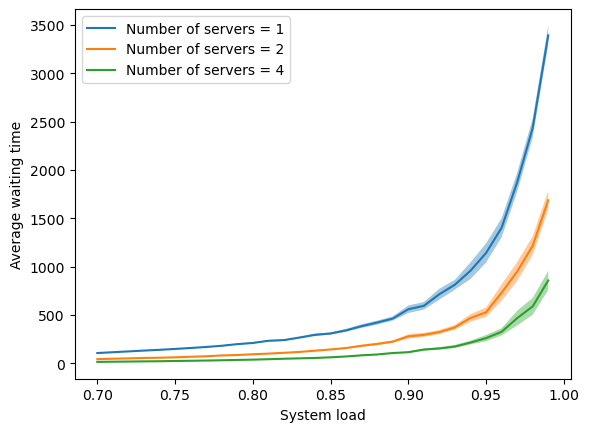

In [8]:
### Question 2, number of simulations
## Takes about 47 minutes to run, if you want faster increase std:min or rhos_step
# Parameters
lambda_ = 0.015
N = 10_000
num_servers_list = [1, 2, 4]

# 'fifo' or 'jsf'
scheduler = 'fifo'

# 'Markov', 'deter' or 'long tail'
mode = 'Markov'
print_statistics = False

rho_min, rho_max = 0.7, 0.99
rhos_step = 0.01

rhos = np.arange(rho_min, rho_max, rhos_step)
mus = lambda_ / rhos

# Number of runs is defined by std_min. Once the standard deviation is less than the std min the simulation stops. 
# Std_min is fixed and universal for all rhos, thus, higher rhos will have higher number of simulations to reach the same std_min
std_min = 50

fig, axs = plt.subplots(dpi=100)
data = generate_waitingtimes2(lambda_, mus, N, num_servers_list, scheduler, mode, std_min)

plot_waitingtimes(data, axs)

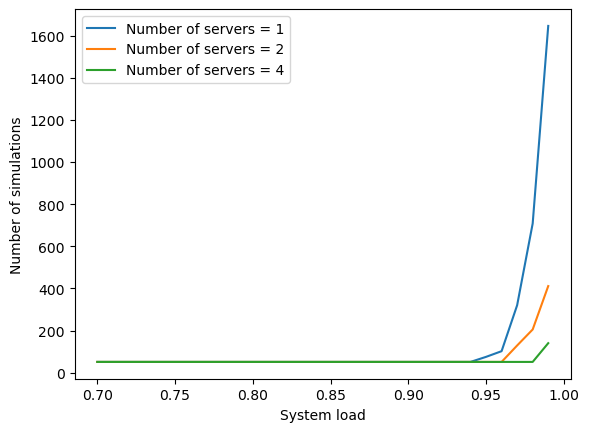

In [14]:
fig, axs = plt.subplots(dpi=100)
plot_nsimulations(data,axs)

## Question 4



In [112]:
lambda_ = 0.015
N = 1000
num_servers_list = [1, 2, 4]

# 'fifo' or 'jsf'
scheduler = 'fifo'

# 'Markov', 'deter' or 'long tail'
print_statistics = False

rho_min, rho_max = 0.01, 1
rhos_step = 0.01



rhos = np.arange(rho_min, rho_max, rhos_step)
mus = lambda_ / rhos

# Number of runs is defined by std_min. Once the standard deviation is less than the std min the simulation stops. 
# Std_min is fixed and universal for all rhos, thus, higher rhos will have higher number of simulations to reach the same std_min
# Once each method is over it stores the data

data_markov = generate_waitingtimes2(lambda_, mus, N, num_servers_list, scheduler, 'Markov', 20)
print("Done with markov")
data_longtail = generate_waitingtimes2(lambda_, mus, N, num_servers_list, scheduler, 'long tail', 150)
print("Done with long tail")
data_deter = generate_waitingtimes2(lambda_, mus, N, num_servers_list, scheduler, 'deter', 10)
print("Done with deter")

In [25]:
data_storer(data_markov,f"Markov_with_N{N}_from{rho_min}_to{rho_max}_with_lambda{lambda_}")
data_storer(data_longtail,f"Longtail_with_N{N}_from{rho_min}_to{rho_max}_with_lambda{lambda_}")
data_storer(data_deter,f"Deter_with_N{N}_from{rho_min}_to{rho_max}_with_lambda{lambda_}")

Text(0.5, 1.0, 'deter')

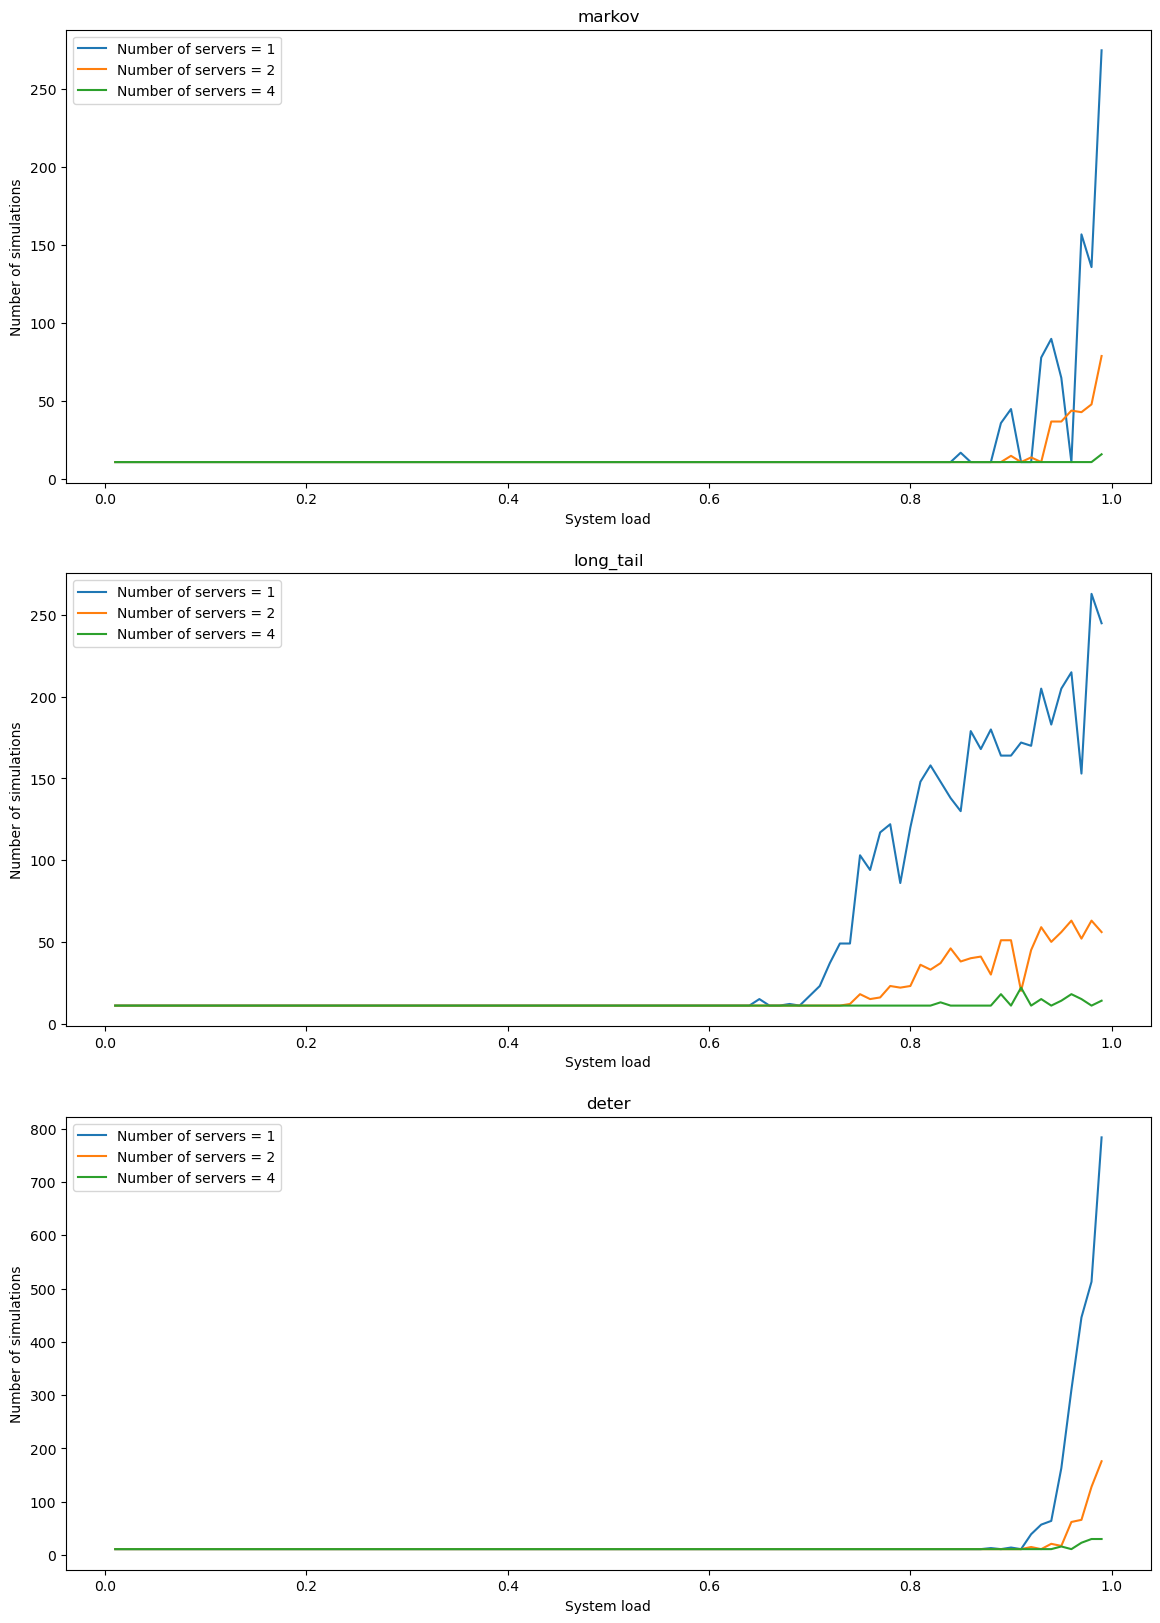

In [104]:
## This plot are only if you think we could include them in q4, but I think is too mauch adding a study of th enumber of simulations, for long tail looks cool
fig, axs = plt.subplots(3,1,figsize =(14,20))


plot_nsimulations(data_markov, axs[0])
axs[0].set_title("markov")
plot_nsimulations(data_longtail, axs[1])
axs[1].set_title("long_tail")
plot_nsimulations(data_deter, axs[2])
axs[2].set_title("deter")

Text(0.5, 1.0, 'M/D/n Average waiting time evolution')

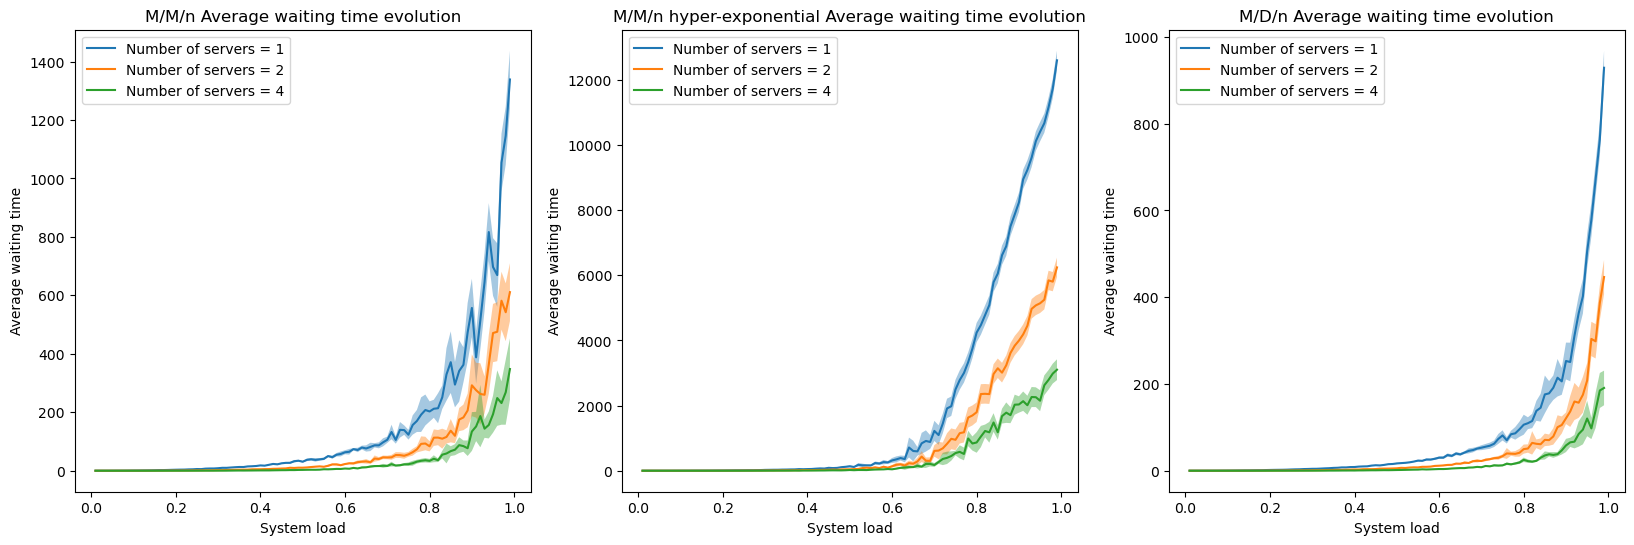

In [105]:
fig, axs = plt.subplots(1,3,figsize =(20,6))


plot_waitingtimes(data_markov, axs[0])
axs[0].set_title("M/M/n Average waiting time evolution")
plot_waitingtimes(data_longtail, axs[1])
axs[1].set_title("M/M/n hyper-exponential Average waiting time evolution")
plot_waitingtimes(data_deter, axs[2])
axs[2].set_title("M/D/n Average waiting time evolution")

In [106]:
print("For deterministic and markov")
welch_test(data_deter, data_markov)
print("\n For long tail and markov")
welch_test(data_longtail, data_markov)
print("\n For long tail and deter")
welch_test(data_deter, data_longtail)

For deterministic and markov
Number of servers is 1
Ttest_indResult(statistic=1.9443701530492195, pvalue=0.053516051283927966)
False
Number of servers is 2
Ttest_indResult(statistic=1.9532966741022855, pvalue=0.052515712540937204)
False
Number of servers is 4
Ttest_indResult(statistic=1.962089492305831, pvalue=0.05156995736905412)
False

 For long tail and markov
Number of servers is 1
Ttest_indResult(statistic=1.9443701530492195, pvalue=0.053516051283927966)
False
Number of servers is 2
Ttest_indResult(statistic=1.9532966741022855, pvalue=0.052515712540937204)
False
Number of servers is 4
Ttest_indResult(statistic=1.962089492305831, pvalue=0.05156995736905412)
False

 For long tail and deter
Number of servers is 1
Ttest_indResult(statistic=1.9443701530492195, pvalue=0.053516051283927966)
False
Number of servers is 2
Ttest_indResult(statistic=1.9532966741022855, pvalue=0.052515712540937204)
False
Number of servers is 4
Ttest_indResult(statistic=1.962089492305831, pvalue=0.0515699573690

In [107]:
regression_test(data_deter,data_markov)

For 1 servers, we reject the null Hypothesis with a  slope of 1.510782282992919 and a pvalue of 5.721159005951872e-75
For 2 servers, we reject the null Hypothesis with a  slope of 1.6189428635090082 and a pvalue of 1.0861960278258615e-68
For 4 servers, we reject the null Hypothesis with a  slope of 1.7709771472058236 and a pvalue of 4.984206276787569e-68


In [108]:
regression_test(data_markov,data_longtail)

For 1 servers, we reject the null Hypothesis with a  slope of 12.639090469708002 and a pvalue of 1.929297304477106e-49
For 2 servers, we reject the null Hypothesis with a  slope of 12.165521295463922 and a pvalue of 1.747672003477817e-51
For 4 servers, we reject the null Hypothesis with a  slope of 11.719560914247058 and a pvalue of 8.663468888769328e-48


In [69]:
print("Correlation matrix")
correlation(data_markov, data_longtail, data_deter)

Correlation matrix
Correlation for 1 servers
             Markov  Long tail     Deter
Markov     1.000000   0.870892  0.990430
Long tail  0.870892   1.000000  0.920311
Deter      0.990430   0.920311  1.000000


Correlation for 2 servers
             Markov  Long tail     Deter
Markov     1.000000   0.853014  0.986360
Long tail  0.853014   1.000000  0.910797
Deter      0.986360   0.910797  1.000000


Correlation for 4 servers
             Markov  Long tail     Deter
Markov     1.000000   0.851906  0.987827
Long tail  0.851906   1.000000  0.909190
Deter      0.987827   0.909190  1.000000




In [95]:
deter = np.array(data_deter[1]["waitingtimes"])
markov = np.array(data_markov[1]["waitingtimes"])
longtail = np.array(data_longtail[1]["waitingtimes"])
print(np.mean(longtail/deter))
print(np.mean(markov/deter))


14.141343572732767
2.045027544207534


In [225]:
data_storer(data_markov, "Markov_rho_from01_01steps_N1000_lamba015")
data_storer(data_longtail, "Longtail_rho_from01_01steps_N1000_lamba015")
data_storer(data_deter, "Deter_rho_from01_01steps_M1000__lamba015")